**Importing Libraries**

In [ ]:
# Import libraries
!pip install pdf2image
!apt install poppler-utils
!apt install libtesseract-dev
!sudo apt install tesseract-ocr
!pip install pytesseract==0.3.9
!pip install tesseract

!pip install Pillow
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import cv2
import sys
import os
import csv
import numpy as np
from google.colab.patches import cv2_imshow

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Adding custom options for tesseract
# OCR Engine Mode(oem) is set to Legacy and LSTM
custom_config = r'--oem 3 --psm 6'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Functions**

In [ ]:
#  Some function for use later in code
# Tesseract image to boxes function on a 3 scale mage
def tessImage2Boxes(img):
    h, w, c = img.shape
    boxes = pytesseract.image_to_boxes(img, config=custom_config)
    for b in boxes.splitlines():
        b = b.split(' ')
        img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (255, 0, 0), 2) #OpenCV is in Blue, Green, Red format
    cv2_imshow(img)

# Tesseract image to boxes function on a grayscale image
def tessImage2Boxes_gray(img):
    h, w = img.shape
    boxes = pytesseract.image_to_boxes(img, config=custom_config)
    for b in boxes.splitlines():
        b = b.split(' ')
        img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (255, 0, 0), 2) #OpenCV is in Blue, Green, Red format
    cv2_imshow(img)

# Function to write jpg and text file to the
def imageToStringTextFile(imgToWrite, newFileBase, theFile):
    #print("file to write :", newFileBase + ".jpg", ", Image shape :", imgToWrite.shape)
    # get file details
    head, tail = os.path.split(theFile)
    #print("head :", head, "tail: ", tail)
    newFileName = head + "/" + newFileBase + tail[17:19]
    print("newFileName :", newFileName)

    # Write the output of the technique to a jpg
    cv2.imwrite(newFileName + ".jpg", imgToWrite)

    # Use tesseract to convert image to string - it extracts the text from the image and saves as text
    text = str(((pytesseract.image_to_string(imgToWrite, lang='eng', config=custom_config))))
    text = text.replace('-\n\n', '')

    # # Finally, write the processed text to the file.
    with open(newFileName+".txt", 'w') as writefile:
        writefile.write(text + "\n")

**Retrieve Files Setup**

In [ ]:
# File Pathname to indicate where to get of file - use google drive
afile = ('/content/gdrive/MyDrive/ComputerVision/Week 5 BOM 2')

# Read the BOM jpg here
aImg = cv2.imread(afile + '/RedactedIsometric5.jpg')
cv2_imshow(aImg)

**Extract Region of Interest**

In [ ]:
aImg.shape

In [43]:
# Define the region of interest - ensure this is as accurate as possible
# Coordinates obtained from MS Paint

# File Pathname to indicate where to get of file - use google drive
afile = ('/content/gdrive/MyDrive/ComputerVision/Week 5 BOM 2')

# Read the BOM jpg here
aImg = cv2.imread(afile + '/RedactedIsometric5.jpg')
# cv2_imshow(aImg)

# I had an error here finding ROI. After several attempts I managed to get a decent result.
# The x and y values needed to be offset by minus one. Solutioin found online.
height, width, _ = aImg.shape

row_start = max(0, min(206, height - 1))
row_end = max(0, min(2841, height))
col_start = max(0, min(5519, width - 1))
col_end = max(0, min(7975, width))

aImg = aImg[row_start:row_end, col_start:col_end]

# Call Function to write jpg and text file
imageToStringTextFile(aImg, "BOM_ROI_5", afile)
# cv2_imshow(aImg)

# Use tesseract to display image of boxes surrounding the text found. Good visual display to see how accurate
# This can be commented out as it doesn't always need to run
# tessImage2Boxes(aImg)

newFileName : /content/gdrive/MyDrive/ComputerVision/BOM_ROI_5


**Convert To GrayScale**

In [ ]:
img1grayscale = aImg.copy()
# Convert to grayscale
img1grayscale = cv2.cvtColor(img1grayscale,cv2.COLOR_BGR2GRAY)

**Binary Threshold**

newFileName : /content/gdrive/MyDrive/ComputerVision/BOM_BIN_5


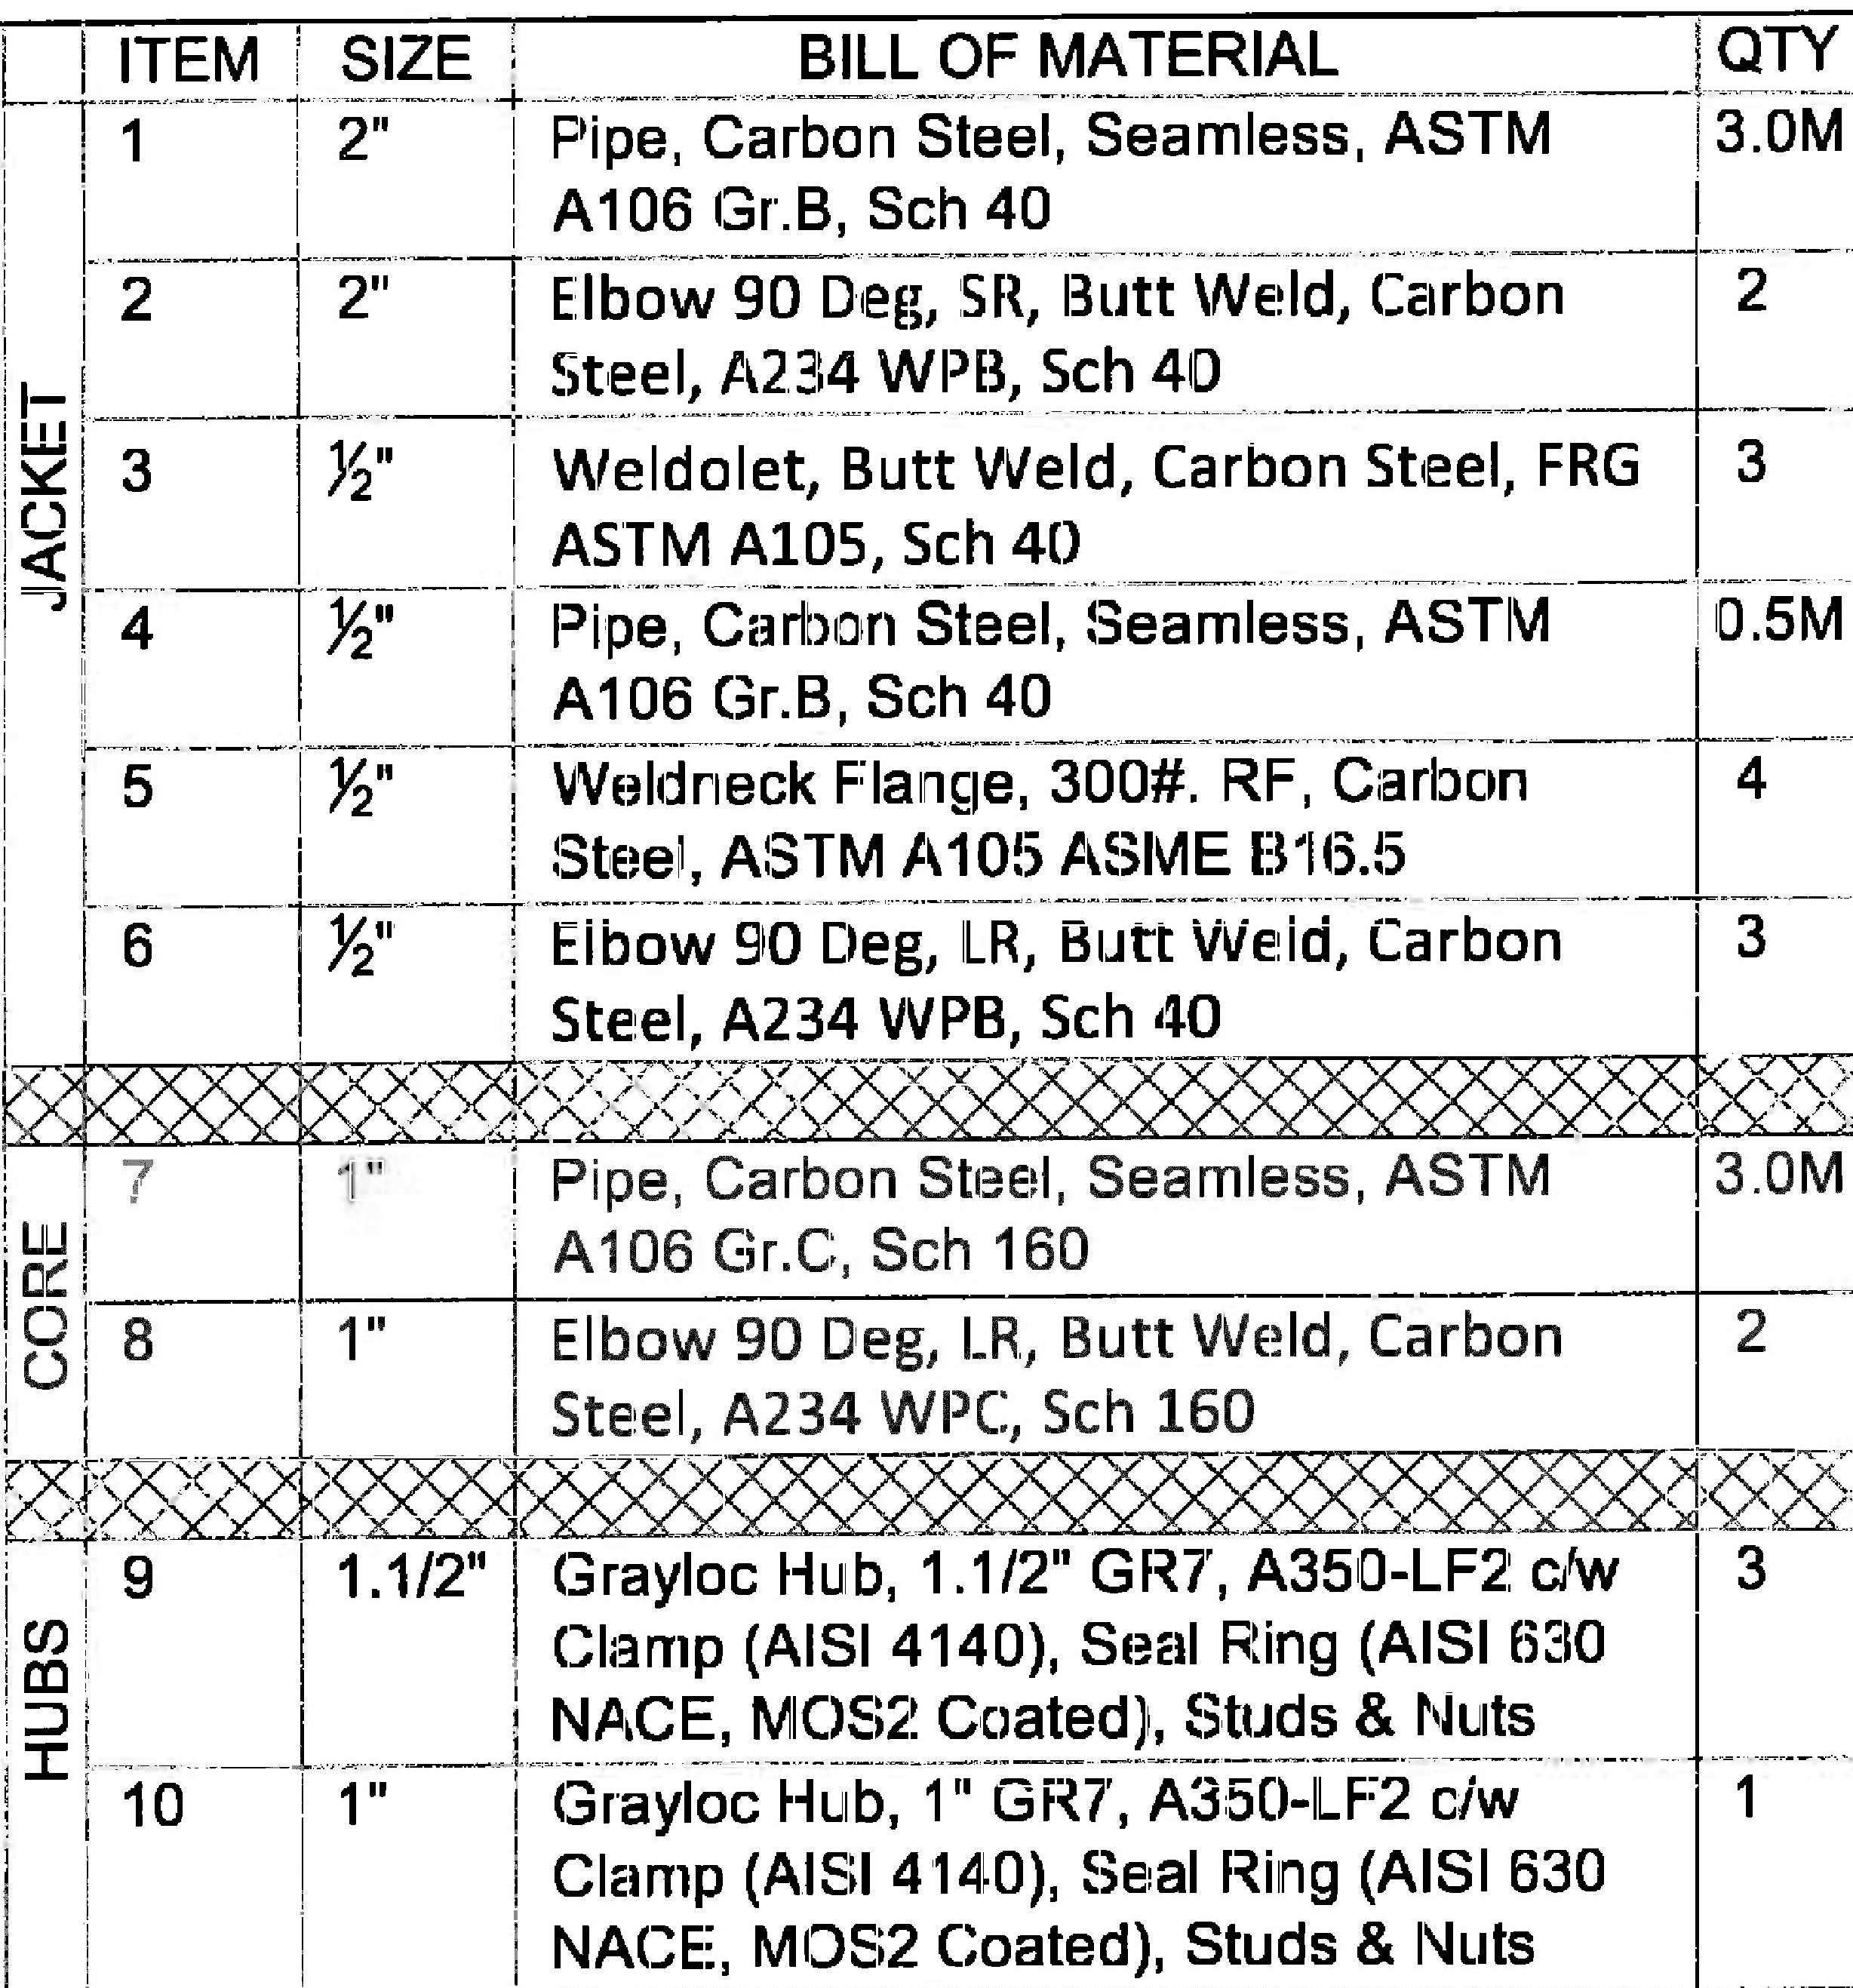

In [ ]:
# Using Simple threshold to improve the ratio rate significantly across all images
# Highest final ratio achieved with Binary ToZero as follows.
ret, imgBin = cv2.threshold(img1grayscale,127,255,cv2.THRESH_TOZERO)

# Call Function to write jpg and text file
imageToStringTextFile(imgBin, "BOM_BIN_5", afile)

# Use tesseract to display image of boxes surrounding the text found. Good visual display to see how accurate
# This can be commented out as it doesn't always need to run
tessImage2Boxes_gray(imgBin)

**Erosion**

In [ ]:
# Inverse Threshold used since Erosion works better with a dark background.
ret, imgBinInv = cv2.threshold(img1grayscale,127,255,cv2.THRESH_BINARY_INV)

# create kernel
kernel = np.ones((3,3),np.uint8)

# Apply erosion to the image
# Spend time finding the correct balance of variables(kernel, iterations)
imgErode = cv2.erode(imgBinInv,kernel,iterations = 1) # inversethresh used here (imgBin) as erosion works better on a dark background.
#cv2_imshow(imgErode)

# Function to write jpg and text file
imageToStringTextFile(imgErode, "BOM_ERO_5", afile)

# Use tesseract to display image of boxes surrounding the text found. Good visual display to see how accurate
# This can be commented out as it doesn't always need to run
# tessImage2Boxes_gray(imgErode)

newFileName : /content/gdrive/MyDrive/ComputerVision/BOM_ERO_5


**Contouring - Horizontal and Vertical lines**

In [ ]:
# # making a copy of the image here as findContours might make changes to original image
imgContour = img1grayscale.copy()

# # Image has to be be in grayscal for the morphologyEx operations to work
#gray = cv2.cvtColor(imgContour, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgContour,127,255,cv2.THRESH_BINARY)

# Horizontal Kernel code here: a horizontal kernel will help to detect all the horizontal line from the image
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2) ) # This kernel yielded best result.
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1) # 1 iteration better here
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# If third column value is NOT equal to -1 than its internal contouring
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
  # Draw the contour
  cv2.drawContours(imgContour, [c], -1, (0,0,0), 1) # Values change to fix fully white image

# Vertical Kernel code here : A verticle kernel which will detect all the verticle lines from the image.
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,3)) # This kernel yeilded best result, trial and error
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2) # 2 iterations here significantly better yet not above
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# If third column value is NOT equal to -1 than its internal contouring
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
  # Draw the contour
  cv2.drawContours(imgContour, [c], -1, (0,0,0), 1) # Values change to fix fully white image

# Function to write jpg and text file
imageToStringTextFile(imgContour, "BOM_HOR_VER_5", afile)

# Use tesseract to display image of boxes surrounding the text found
#tessImage2Boxes_gray(imgContour)

**Erosion and Contouring**

newFileName : /content/gdrive/MyDrive/ComputerVision/BOM_ERO_HOR_VER_5


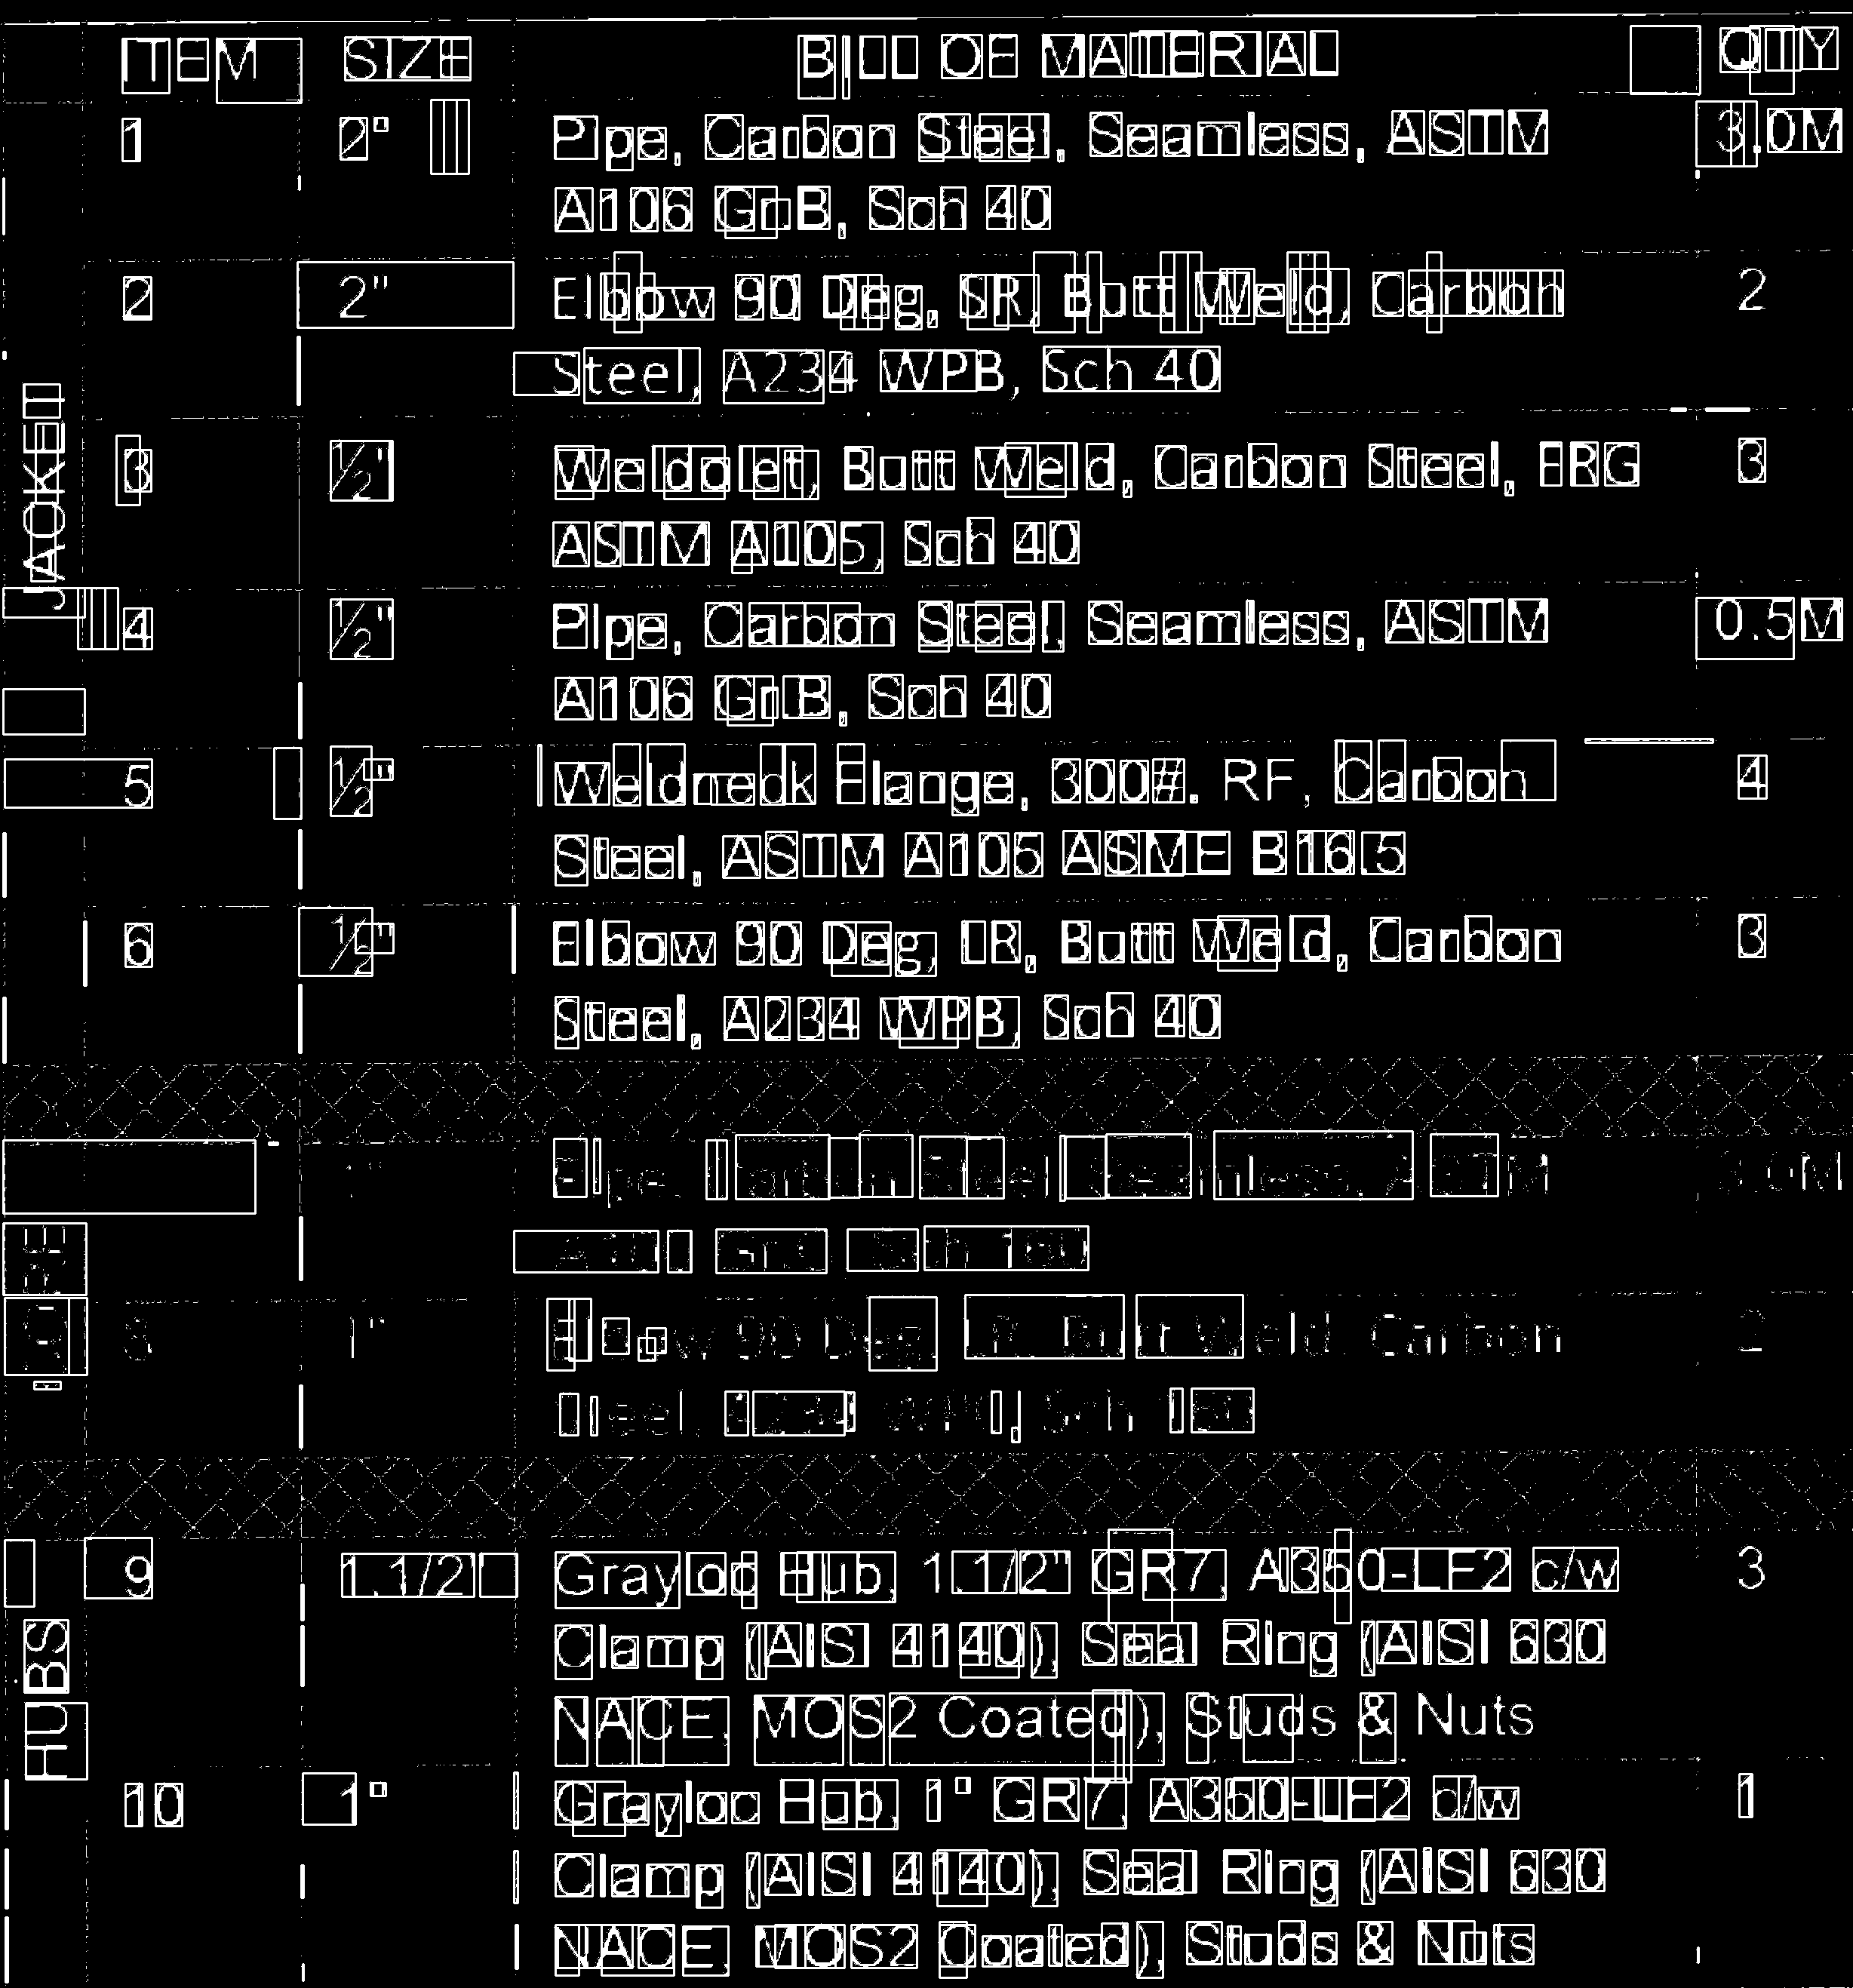

In [38]:
# apply contouring to the eroded image

# # making a copy of the image here as findContours might make changes to original image
result = imgErode.copy()
# # Image has to be be in grayscal for the morphologyEx operations to work
# gray =
ret, thresh = cv2.threshold(result,127,255,cv2.THRESH_BINARY)

# Horizontal Kernel
# These values will not give the best result - you are expected to explore different values
# This kernel yeilded best result, trial and error
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2) )
horizontal_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
cnts = cv2.findContours(horizontal_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
  cv2.drawContours(result, [c], -1, (0,0,0), 1)

# Vertical Kernel
# These values will not give the best result - you are expected to explore different values
# This kernel yeilded best result, trial and error
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,3))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
  cv2.drawContours(result, [c], -1, (0,0,0), 1)

# Function to write jpg and text file
imageToStringTextFile(result, "BOM_ERO_HOR_VER_5", afile)

# Use tesseract to display image of boxes surrounding the text found
tessImage2Boxes_gray(result)

**Contouring and then Erosion**
you are here

In [39]:
kernel = np.ones((2,2),np.uint8)

imgContour2 = imgContour.copy()

contErode =  cv2.erode(imgContour2,kernel,iterations = 2)

# Function to write jpg and text file
imageToStringTextFile(contErode, "BOM_HOR_VER_ERO_5", afile)

# Use tesseract to display image of boxes surrounding the text found. Good visual display to see how accurate
# This can be commented out as it doesn't always need to run
#tessImage2Boxes_gray(contErode)

newFileName : /content/gdrive/MyDrive/ComputerVision/BOM_HOR_VER_ERO_5


**Blurring**

In [40]:
imgBlur = cv2.imread(afile + '/RedactedIsometric5.jpg')

imgBlur = imgBlur[219:1507, 5849:8036]

#Highest end number attained with median blur
imgBlur = cv2.medianBlur(imgBlur,3) # Changed to diff (oddnumbered) parameters. 3=best

# Function to write jpg and text file
imageToStringTextFile(imgBlur, "BOM_BLUR_5", afile)

# Use tesseract to display image of boxes surrounding the text found. Good visual display to see how accurate
# This can be commented out as it doesn't always need to run
# tessImage2Boxes(imgBlur)

newFileName : /content/gdrive/MyDrive/ComputerVision/BOM_BLUR_5


**Contouring and then Blurring**

In [41]:
# Applying a blur can help reduce noise, again making it easier for Tesseract to correctly OCR the image

imgContBlur = imgContour.copy()
# use the image that has contouring applied, now apply blurring
imgContBlur = cv2.bilateralFilter(imgContBlur,d=3, sigmaColor=75, sigmaSpace=75)

# Function to write jpg and text file
imageToStringTextFile(imgContBlur, "BOM_HOR_VER_BLUR_5", afile)

# Use tesseract to display image of boxes surrounding the text found. Good visual display to see how accurate
# This can be commented out as it doesn't always need to run
# tessImage2Boxes_gray(imgContBlur)

newFileName : /content/gdrive/MyDrive/ComputerVision/BOM_HOR_VER_BLUR_5


In [42]:
# Comparing Ground truth with the ROI
from difflib import SequenceMatcher

ratioResults = []


# Read text files
with open('/content/gdrive/MyDrive/ComputerVision/Week 5 BOM 2/GroundTruth-BOM5.txt', 'r') as f:
    groundTruth = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_ROI_5.txt', 'r') as f:
    roi = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_BIN_5.txt', 'r') as f:
    bin = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_ERO_5.txt', 'r') as f:
    erode = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_HOR_VER_5.txt', 'r') as f:
    hor_ver = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_ERO_HOR_VER_5.txt', 'r') as f:
    erode_hor_ver = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_HOR_VER_ERO_5.txt', 'r') as f:
    hor_ver_erode = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_BLUR_5.txt', 'r') as f:
    blur = f.read()

with open('/content/gdrive/MyDrive/ComputerVision/BOM_HOR_VER_BLUR_5.txt', 'r') as f:
    hor_ver_blur = f.read()

# SequenceMatcher Compares pairs of sequences
# comparing the grountruth data (was supplied with assignment) against the output text file created from each of the methods applied above
gt_roi = SequenceMatcher(None, groundTruth, roi)
gt_bin = SequenceMatcher(None, groundTruth, bin)
gt_erode = SequenceMatcher(None, groundTruth, erode)
gt_hor_ver = SequenceMatcher(None, groundTruth, hor_ver)
gt_erode_hor_ver = SequenceMatcher(None, groundTruth, erode_hor_ver)
gt_hor_ver_erode = SequenceMatcher(None, groundTruth, hor_ver_erode)
gt_blur = SequenceMatcher(None, groundTruth, blur)
gt_hor_ver_blur = SequenceMatcher(None, groundTruth, hor_ver_blur)

# Create variables for the the headings and values
headings = ["  ROI", "Binary", "Erosion", "Contour", "Erode&Cont", "Cont&Erode", " Blur","Cont&Blur"]
values = [gt_roi.ratio(), gt_bin.ratio(), gt_erode.ratio(), gt_hor_ver.ratio(), gt_erode_hor_ver.ratio(), gt_hor_ver_erode.ratio(),gt_blur.ratio(), gt_hor_ver_blur.ratio()]

# Print headings in a row
print("{:<7} {:<7} {:<7} {:<7} {:<10} {:<10} {:<10} {:<10}".format(*headings))
# Print row of values(formatted to 4 decimal places)
print("{:<7.4f} {:<7.4f} {:<7.4f} {:<7.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(*values))


# Store ratioResults rounded to four decimal places
#ratioResults.extend([round(value, 4) for value in values]) # Using list comprehension

  ROI   Binary  Erosion Contour Erode&Cont Cont&Erode  Blur      Cont&Blur 
0.3712  0.7226  0.5253  0.7503  0.2897     0.8011     0.4782     0.7043    


**Save to CSV**

In [44]:
import csv
# Open CSV in write mode and save to drive
with open('/content/gdrive/MyDrive/ComputerVision/ratios_BOM5.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(headings)  # The row of headings
    csv_writer.writerow(ratioResults)  # The row of values